# SABR model calibration note
--- Shaolun.du@gmail.com, 2020-08-09

This is a note on SABR normal volatility calibration. The SABR model describes a single forward ${\displaystyle F}$, such as a LIBOR forward rate, a forward swap rate, or a forward stock price. This is one of the standards in market used by market participants to quote volatilities. The volatility of the forward ${\displaystyle F}$ is described by a parameter ${\displaystyle \sigma }$ . SABR is a dynamic model in which both ${\displaystyle F}$ and ${\displaystyle \sigma }$  are represented by stochastic state variables whose time evolution is given by the following system of stochastic differential equations:
$$
\begin{aligned}
dF_t &= \sigma_{t}(F_t)^{\beta}dW_t \\
d\sigma_{t} &= \alpha*\sigma_{t}dZ_{t} \\
\end{aligned}
$$
With constant parameters $\beta$, $\alpha$ satisfy the conditions $0<=\beta<=1$, $\alpha >= 0$, here $\alpha$ is the volatility of volatility (VolVol) and correlation coefficient $-1<\rho <1$:
$$
\begin{aligned}
dW_{t}dZ_{t} &= \rho dt
\end{aligned}
$$
With the following initial condition:
$$
\begin{aligned}
F(0) &= F_0 \\
\sigma(0) &= \sigma_{0}
\end{aligned}
$$

For SABR model there is no known closed form option caluation formula. Instead, we take the following approach by forcing the valuation formula the be of the form:
$$
\begin{aligned}
Call(T,K,F_0,\sigma) &= Z_0[F_0N(d_{+})-KN(d_{-}))] \\
Put(T,K,F_0,\sigma) &= Z_0[-F_0N(-d_{+})+KN(-d_{-}))] \\
d_{+-} &= \frac{log(F_0/K)+-0.5*\sigma^2T}{\sigma*{T}^{0.5}}
\end{aligned}
$$

For the implied normal volatility formula we have an asymptotic expansion answer which requires $\alpha^2 T<<1$. The approximated implied volatility is given by:

$$
\begin{aligned}
\sigma(T,K,F_0,sigma_0,\alpha,\beta,\rho) &= \alpha*\frac{F_0-K}{D(\epsilon)}*[1+[A + B+C]] \\
A &= \frac{2*\gamma_2-\gamma_1^2}{24}*(\frac{\sigma_0*F_{mid}^{\beta}}{\alpha})^2 \\
B &= \frac{\rho*\gamma_1*\sigma_0*F_{mid}^{\beta}}{4*\alpha} \\
C &= \frac{2-3*\rho^2}{24} \\
\end{aligned}
$$

With the following expression:
$$
\gamma_1 = \frac{\beta}{F_{mid}},\gamma_2=\frac{\beta*(\beta-1)}{F_{mid}^2}, F_{mid} = \frac{F_0+K}{2}
$$
The distance function $D(\epsilon)$ is given by:
$$
\begin{aligned}
D(\epsilon) &= log(\frac{(1-2\rho*\epsilon+\epsilon^2)^{0.5}+\epsilon-\rho}{1-\rho}) \\
\epsilon &= \frac{\alpha}{\sigma_0}\int_K^{F_0}\frac{dx}{x^{\beta}} = \frac{\alpha}{\sigma_0(1-\beta)}(F_0^{1-\beta}-K^{1-\beta})
\end{aligned}
$$

We will do the calibration procedure as following:
 * For each option maturity we need four model parameters: $\sigma_0,\alpha,\beta,\rho$, we choose then so that the model matches the market implied vols for several different strikes. We can calibrates the model by fixing $\beta$ first.
 * For a fixed $\beta<=1$, we can choose $\beta=0.5$, we calibrate $\sigma_0,\alpha,\rho$.
 * Typically, the parameter $\alpha$ which starts out high for short dated options and then declines monotonically as the option expiration increases.
 
The last thing is to make sure there is no arbitrage situation in SABR model:
 * Put-call parity, this condition holds automatically since we are using the smae implied volatility $\sigma$ for both calls and puts.
 * The terminal probability desitu function implied by the call and put prices needs to be positive.

## Part One SABR calibration for Swaptions

In the following example I will use USD 1Y5Y swaption as calibration example to show how the fitness of SABR model could be.

The market panel information looks like this:

|  Strike | Market_Vol(BPS)  | Model_Vol(BPS)  | \|Diff\|(BPS)  |
|---|---|---|---|
| ATM-200  | 68.31  | 68.58  |  0.27 |
| ATM-100 | 54.39  | 54.50  |  0.11 |
| ATM-75  | 50.91  | 50.98  |  0.07 |
| ATM-50  | 47.81  | 47.81  |  0 |
| ATM-25  |  45.55 | 45.48  |  0.07 |
| ATM  | 44.8  | 44.64  | 0.16 |
| ATM+25  | 45.99  | 45.82  | 0.17  |
| ATM+50  | 48.83  |  48.66 |  0.23 |
| ATM+75  | 52.77  | 52.55  |  0.22 |
| ATM+100  | 57.13  | 56.98  |  0.15 |
| ATM+200  | 76.28 | 76.20  |  0.08 |

As shown in the table, the overall calibration is almost perfect the biggest difference is 0.27bps and on average the difference is 0.14bps.

In [1]:
# Import dependent library
from abc import ABCMeta, abstractmethod
from scipy.optimize import minimize
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import math
import matplotlib.pyplot as plt

In [2]:
class BaseSABR(metaclass=ABCMeta):
    """Base class for SABR models."""
    
    def __init__(self, f=0.01, shift=0., t=1.0, v_atm_n=0.0010,
                 beta=1., rho=0., sig0=0., alpha = 0.):
        self.f = f
        self.t = t
        self.shift = shift # Shift method applied when strike/fwd is negative
        self.beta = beta
        self.rho = rho
        self.sig0 = sig0
        self.alpha = alpha

    @abstractmethod
    def fit(self, k, v):
        """Best fit the model to a discrete volatility smile."""

    @abstractmethod
    def normal_vol(self, k):
        """Return normal volatility for a given strike."""
        
    @abstractmethod
    def lognormal_vol(self, k):
        """Return normal volatility for a given strike."""
        
    def density(self, k):
        """Compute the probability density function from call prices."""
        std_dev = self.v_atm_n * np.sqrt(self.t)
        dk = 1e-4 * std_dev
        d2call = self.call(k+dk) - 2 * self.call(k) + self.call(k-dk)
        return d2call / dk**2

    def get_params(self):
        """Get parameters for this SABR model."""
        return self.__dict__

    def __repr__(self):
        class_name = self.__class__.__name__
        return (class_name, _pprint(self.__dict__))


In [3]:
class NormalSABR(BaseSABR):
    def lognormal_vol(self):
        """ Method for lognormal vol pricing"""
        pass
    
    def normal_vol(self, k):
        """Return normal volatility for a given strike."""
        f, s, t = self.f, self.shift, self.t
        beta, rho, sig0, alpha = self.beta, self.rho, self.sig0, self.alpha
        v_n = normal_vol_new(k+s, f+s, t, alpha, beta, rho, sig0)
        return v_n

    def fit(self, k, v_sln):
        """
        Calibrate SABR parameters alpha, rho and volvol.
        Best fit a smile of shifted normal volatilities passed through
        arrays k and v. 
        Returns a tuple of SABR params (alpha, rho, volvol)
        """
        f, s, t, beta = self.f, self.shift, self.t, self.beta
        def vol_square_error(x):
            vols = [normal_vol_new( k_+s, f+s, t, x[0], beta, x[1],
                                    x[2]) for k_ in k]
            return sum((vols - v_sln)**2)

        x0 = np.array([0.1, 0.01, 0.01])
        bounds = [(0.000001, None), (-0.9999, 0.9999), (0.000001, None)]
        res = minimize(vol_square_error, x0, method='TNC', bounds=bounds, tol=1e-10)
        self.alpha, self.rho, self.sig0 = res.x
        return [self.alpha, self.rho, self.sig0],res

# Helpers functions below:
def normal_vol_new(k, f, t, alpha, beta, rho, sig0):
    # We break down the complex formula into simpler sub-components
    f_mid = (f+k)/2
    ki_1 = beta/f_mid
    ki_2 = beta*(beta-1)/f_mid**2
    kesi = alpha/(sig0*(1-beta))*(f**(1-beta)-k**(1-beta))
    # Distance function below
    # when kesi is VERY small this function will be NA
    if abs(f-k) >= 1e-5:
        dist = math.log((math.sqrt(1-2*rho*kesi+kesi**2)+kesi-rho)/(1-rho))
        FMKR = (f-k)/dist
    else:
        # Use numerical approximation
        f_temp = f+1e-5
        kesi = alpha/(sig0*(1-beta))*(f_temp**(1-beta)-k**(1-beta))
        dist = math.log((math.sqrt(1-2*rho*kesi+kesi**2)+kesi-rho)/(1-rho))
        FMKR = (f_temp-k)/dist
        
    C_f_mid = f_mid**(beta)
    A = (2*ki_2-ki_1**2)/24*(sig0*C_f_mid/alpha)**2
    B = rho*ki_1/4*sig0*C_f_mid/alpha
    C = (2-3*rho**2)/24
    v_n = alpha * FMKR * (1 + (A + B + C)*t*alpha**2)
    return v_n

In [4]:
# Testing plot of SABR model
# Using USD swap vol 1Y*5Y as example:
bps_unit = 10000
f_ATM = 0.0038
maturity = 1
beta_fix = 0.5
sabr = NormalSABR(f=f_ATM*bps_unit, shift=0.03*bps_unit, 
                  t=maturity, beta=beta_fix)
# Vol stike panle defined in the same structure as in BBG VCUB
k = np.array([ f_ATM-0.02,f_ATM-0.01,f_ATM-0.0075,f_ATM-0.005,f_ATM-0.0025,
               f_ATM,
               f_ATM+0.0025,f_ATM+0.005,f_ATM+0.0075,f_ATM+0.01,f_ATM+0.02])*bps_unit
v_sln = np.array([ 68.31, 54.39, 50.91, 47.81, 45.55,
                   44.8, 
                   45.99, 48.83, 52.77, 57.13, 76.28])
[alpha, rho, sig0],res = sabr.fit(k, v_sln)
print("Calibrated result: Alpha={:0.4f},Rho={:0.4f},Sigma_0={:0.4f}".format(alpha,rho,sig0))

Calibrated result: Alpha=0.6436,Rho=-0.0751,Sigma_0=2.3595


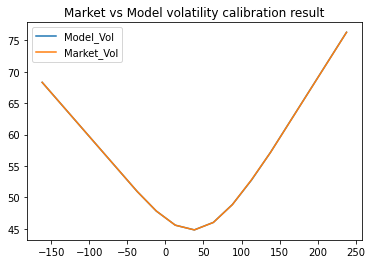

In [5]:
model_vol = [sabr.normal_vol(kk) for kk in k]
plt.plot(k,model_vol,label="Model_Vol")
plt.plot(k,v_sln,label="Market_Vol")
plt.title("Market vs Model volatility calibration result")
plt.legend()
plt.show()

### Model investigation
We further look into model calibration features, we will plot the relationship of calibration with different maturities with alpha, rho and sigma_0.

Market volatility cube looks like below:

USD swaption date 2020-08-10, source: bloomberg

In [6]:
# Collaction of market swaption volatility cube
test_swaption_pan = [
    {"ticker":"3M5Y","mat":3/12,
     "strike":[-0.0169,-0.0069,-0.0044,-0.0019,0.0006,0.0031,0.0056,0.0081,0.0106,0.0131,0.0231],
     "vol":[100.4,68.8,60.5,51.5,42.1,38.1,43.9,53.9,64.4,74.7,113.9]},
    {"ticker":"1Y5Y","mat":1.0,
     "strike":[-0.0162,-0.0062,-0.0037,-0.0012,0.0013,0.0038,0.0063,0.0088,0.0113,0.0138,0.0238],
     "vol":[68.5,54.7,51.9,47.8,45.5,44.7,46,48.8,52.7,60.1,76.4]},
    {"ticker":"3Y5Y","mat":3.0,
     "strike":[-0.0136,-0.0036,-0.0011,0.0014,0.0039,0.0064,0.0089,0.0114,0.0139,0.0164,0.0264],
     "vol":[63.5,58.3,57.3,56.5,56,56,56.4,57.3,58.6,60.3,69.5]},
    {"ticker":"5Y5Y","mat":5.0,
     "strike":[-0.0112,-0.0012,0.0013,0.0038,0.0063,0.0088,0.0113,0.0138,0.0163,0.0188,0.0288],
     "vol":[61.6,60.6,60.5,60.5,60.8,61.1,61.7,62.3,63.3,64.4,69]},
    {"ticker":"10Y5Y","mat":10.0,
     "strike":[-0.0092,0.0008,0.0033,0.0058,0.0083,0.0108,0.0133,0.0158,0.0183,0.0208,0.0308],
     "vol":[62.4,62.6,62.5,62.7,63,63.3,63.6,64,64.5,65.1,69]},
    {"ticker":"20Y5Y","mat":20.0,
     "strike":[-0.0104,-0.0004,0.0021,0.0046,0.0071,0.0096,0.0121,0.0146,0.0171,0.0196,0.0296],
     "vol":[55.5,55.9,56,56.1,56.3,56.6,56.9,57.4,58.1,58.8,61.8]},
]

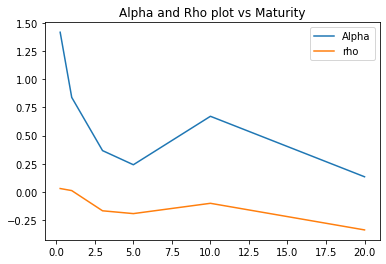

In [7]:
# Analyze of alpha as maturity increase
bps_unit = 10000
answer = []
for t_swap in test_swaption_pan:
    f_ATM = t_swap["strike"][5]
    maturity = t_swap["mat"]
    beta_fix = 0.5
    sabr = NormalSABR(f=f_ATM*bps_unit, shift=0.03*bps_unit, 
                      t=maturity, beta=beta_fix)
    # Vol stike panle defined in the same structure as in BBG VCUB
    k = np.array(t_swap["strike"])*bps_unit
    v_sln = np.array(t_swap["vol"])
    [alpha, rho, sig0],res = sabr.fit(k, v_sln)
    answer.append({"mat":t_swap["mat"],
                   "alpha":alpha,
                   "rho":rho,
                   "sig0":sig0,})
mat_li = [ele["mat"] for ele in answer]
plt.plot(mat_li,[ele["alpha"] for ele in answer],label="Alpha")
plt.plot(mat_li,[ele["rho"] for ele in answer],label="rho")
plt.title("Alpha and Rho plot vs Maturity")
plt.legend()
plt.show()

## Part Two SABR calibration for FX options

We will apply SABR model on FX option volatility calibration, the major difference is FX option market quote in RR(risk-reversal) and BF(butterfly). The first task is to convert RR,BF,ATM quote into standard (Strike-Volatility) panel.

**NOTE**: Since FX market always has rates bigger than 0, we do not have negative rates error. All volatility quotes will be in log-normal convention. We also have to rewrite SABR calibration object for log-normal volatility surface.


In [8]:
class LogNormalSABR(BaseSABR):
    def normal_vol(self):
        """ Method for normal vol pricing"""
        pass
    
    def lognormal_vol(self, k):
        """Return normal volatility for a given strike."""
        f, s, t = self.f, self.shift, self.t
        beta, rho, sig0, alpha = self.beta, self.rho, self.sig0, self.alpha
        v_n = lognormal_vol_new(k+s, f+s, t, alpha, beta, rho, sig0)
        return v_n

    def fit(self, k, v_sln):
        """
        Calibrate SABR parameters alpha, rho and volvol.
        Best fit a smile of shifted normal volatilities passed through
        arrays k and v. 
        Returns a tuple of SABR params (alpha, rho, volvol)
        """
        f, s, t, beta = self.f, self.shift, self.t, self.beta
        def vol_square_error(x):
            vols = [lognormal_vol_new( k_+s, f+s, t, 
                                       x[0], beta, x[1],
                                       x[2]) for k_ in k]
            return sum((vols - v_sln)**2)

        x0 = np.array([1, 0.5, 1])
        bounds = [(0.000001, None), (-0.9999, 0.9999), (0.000001, None)]
        res = minimize(vol_square_error, x0, method='TNC', bounds=bounds, tol=1e-10)
        self.alpha, self.rho, self.sig0 = res.x
        return [self.alpha, self.rho, self.sig0],res

# Helpers functions below:
def lognormal_vol_new(k, f, t, alpha, beta, rho, sig0):
    # Negative strikes or forwards
    if k <= 0 or f <= 0:
        return 0.
    eps = 1e-07
    logfk = np.log(f / k)
    fkbeta = (f*k)**(1 - beta)
    a = (1 - beta)**2 * alpha**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * sig0 * alpha / fkbeta**0.5
    c = (2 - 3*rho**2) * sig0**2 / 24
    d = fkbeta**0.5
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920
    z = sig0 * fkbeta**0.5 * logfk / alpha
    # if |z| > eps
    if abs(z) > eps:
        vz = alpha * z * (1 + (a + b + c) * t) / (d * (1 + v + w) * _x(rho, z))
        return vz
    # if |z| <= eps
    else:
        v0 = alpha * (1 + (a + b + c) * t) / (d * (1 + v + w))
        return v0
    
def _x(rho, z):
    """Return function x used in Hagan's 2002 SABR lognormal vol expansion."""
    a = (1 - 2*rho*z + z**2)**.5 + z - rho
    b = 1 - rho
    return np.log(a / b)  

### FX volatility market conversion
For a call fx option we have the below delta quotations:

|  Spot Delta | Forward Delta  | Adjusted Spot Delta  | Adjusted Forward Delta  |
|------|------|------|------|
| $e^{-r_f*t}N(d_{+})$  | $N(d_{+})$  | $e^{-r_f*t}\frac{K}{f}N(d_{-})$  |  $\frac{K}{f}N(d_{-})$ |

Where,
$$
\begin{aligned}
d_{+} &= \frac{log(\frac{S}{K})+(r_d-r_f+vol^2/2)T}{vol*T^{0.5}}\\
d_{-} &= d_{+}-vol*T^{0.5} \\
\end{aligned}
$$

We have an option normal volatility panel like below, EURUSD 3M option quotation:


|  Maturity |  ATM  | 25D RR  | 25D BF  | 10D RR  |  10D BF  |
|------|------|------|------|------|------|
| 3M | 8.06  | 0.57  |  0.28 | 1.03  |  0.89 |

As shown in the following code after translation we have the (Strike,Vol) panel:

|  Items |  ATM  | 25D_C  | 25D_P  | 10D_C  |  10D_P  |
|------|------|------|------|------|------|
|  Strike |  1.1815  | 1.2209  | 1.1537  | 1.2605  |  1.123  |
| Vol | 8.06  | 8.625  |  8.055 | 9.465  |  8.435 |

In [9]:
def market_quote(market_dict):
    # Convert market dictionary into put/call delta
    # market quote are in spot delta convention
    ans_dict = {}
    ans_dict["Maturity"] = market_dict["Maturity"]
    ans_dict["ATM"] = market_dict["ATM"]
    ans_dict["25D_C"] = market_dict["ATM"]+0.5*market_dict["25D_RR"]+market_dict["25D_BF"]
    ans_dict["25D_P"] = -market_dict["25D_RR"]+ans_dict["25D_C"]
    ans_dict["10D_C"] = market_dict["ATM"]+0.5*market_dict["10D_RR"]+market_dict["10D_BF"]
    ans_dict["10D_P"] = -market_dict["10D_RR"]+ans_dict["10D_C"]
    return ans_dict

def blk_spot_delta(K, delta,R_d,R_f,vol,f,live_t,is_call):
    """ Black log-normal Delta formula FX option"""
    d1 = is_call*(math.log(f/K)+(R_d-R_f+vol**2)*live_t)/(vol*math.sqrt(live_t))
    # call option delta > 0, put option delta < 0
    fun = is_call*delta-is_call*math.exp(-R_f*live_t)*norm.cdf(d1)
    return fun

def delta_2_strike( i_type, delta, paras ):
    # solve strike given delta
    # Assuming market panel has format in "market_quote"
    if i_type == "Spot":
        add_agrs = (delta,paras["R_d"],paras["R_f"],paras["vol"],paras["f"],paras["live_t"],paras["is_call"])
        x_start = paras["f"]
        K = fsolve(blk_spot_delta, x0=x_start, args=add_agrs)[0]
    elif i_type == "Fwd":
        raise NotImplmentedError
    elif i_type == "Spot_Adj":
        raise NotImplmentedError
    elif i_type == "Fwd_Adj":
        raise NotImplmentedError
    return K

def convert_panel(panel, r_f, r_d, s, f):
    # Convert market panel into put/call strike-vol structure
    ans = []
    paras = {}
    live_t = panel["Maturity"]/12
    for key,vol in panel.items():
        if key != "Maturity":
            paras["live_t"] = live_t
            paras["vol"] = vol/100
            paras["R_f"] = r_f
            paras["R_d"] = r_d
            paras["S"] = s
            paras["f"] = f
            if key != "ATM":
                paras["is_call"] = {"C":1,"P":-1}[key.split("_")[1]]
                delta = int(key.split("_")[0][:-1])/100
                strike = delta_2_strike("Spot",delta,paras) #Spot delta quotation
            else:
                paras["is_call"] = 1
                delta = 0.5
                strike = f
            ans.append({"strike":strike,"vol":vol,"opt":key,"is_call":paras["is_call"]})
    return ans

In [10]:
# Market_dict
market_dict = {}
market_dict["Maturity"] = 3
market_dict["ATM"] = 8.06
market_dict["25D_RR"] = 0.57
market_dict["25D_BF"] = 0.28
market_dict["10D_RR"] = 1.03
market_dict["10D_BF"] = 0.89
panel = market_quote(market_dict)
R_d = 0.0007
R_f = -0.0067
S = 1.1793
f = 1.1815
converted = convert_panel(panel,R_f,R_d,S,f)
converted = sorted(converted,key=lambda x:x["strike"])
strike_li = [ele["strike"] for ele in converted]
vol_li = [ele["vol"] for ele in converted]

In [11]:
# Testing plot of SABR model
# Using USD swap vol 1Y*5Y as example:
pct_unit = 100
f_ATM = 1.1815
maturity = 3/12
beta_fix = 0.5
logn_sabr = LogNormalSABR( f=f_ATM, shift=0., 
                           t=maturity, beta=beta_fix)
fxo_k = np.array(strike_li)
fxo_v_sln = np.array(vol_li)/pct_unit
[alpha, rho, sig0],res = logn_sabr.fit(fxo_k, fxo_v_sln)
print("Alpha={:0.4f},Rho={:0.4f},Sigma_0={:0.4f}".format(alpha,rho,sig0))

Alpha=0.0854,Rho=0.1579,Sigma_0=1.1783


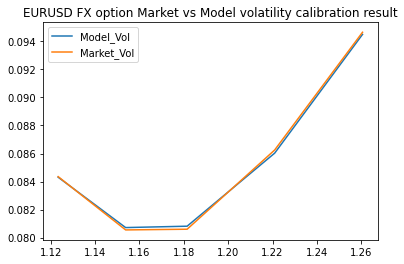

In [12]:
model_vol = [logn_sabr.lognormal_vol(kk) for kk in fxo_k]
plt.plot(fxo_k,model_vol,label="Model_Vol")
plt.plot(fxo_k,fxo_v_sln,label="Market_Vol")
plt.title("EURUSD FX option Market vs Model volatility calibration result")
plt.legend()
plt.show()

## Summary
In this note book, I list out calibration method for both normal and log-normal volatility surface using SABR model. The overall fitting is preety good and I have implemented it against bloomberg pricing. 

As the maturity increase, the alpha paramater tends to be lower and lower, and so does the rho paramater. When the maturity is super small, the alpa could be very large which causing the model to be not stable.

* It turns out that there is a bit of redundancy between the parameters beta and alpha As a result, one usually calibrates the model by fixing .
* For a fixed beta <= 1, say beta = 0.5, we calibrate alpha, alpha, rho. This works quite well under “normal” conditions.
* The SABR model can be calibrated to match the market in a variety of conditions.
* Calibration results show a persistent term structure of the model parameters as functions of option expiration: typical is the shape of the parameter alpha which starts out high for short dated options and then declines monotonically as the option expiration increases.